In [1]:
import numpy as np
import pandas as pd
import h5py

import torch

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

A class to cluster the data and to evaluate it.

In [2]:
class KMeansEvaluator:
    def __init__(self, data, n_clusters, cluster_colors, true_labels=None):
        """
        Initializes the KMeansEvaluator class.
        
        Parameters:
        - data: The data to cluster (should be in 2D array-like format).
        - n_clusters: The number of clusters for KMeans.
        - true_labels: Optional. True labels of the data to calculate cluster purity.
        """
        self.data = data
        self.n_clusters = n_clusters
        self.colors = cluster_colors
        self.true_labels = true_labels
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        
    def fit(self):
        """Fits the KMeans model and stores the results."""
        # Step 1: Standardize the features
        n_samples, n_features, n_timesteps = self.data.shape
        data_reshaped = self.data.reshape(n_samples, -1)
        print(f'The shape of data after reshaping: {data_reshaped.shape}')
        self.data_scaled = self.scaler.fit_transform(data_reshaped)
        
        # Step 2: Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42)
        self.data_tsne = tsne.fit_transform(self.data_scaled)
        
        # Step 3: Fit KMeans clustering
        self.cluster_labels = self.kmeans.fit_predict(self.data_tsne)
        self.centroids = self.kmeans.cluster_centers_
        print('Done clustering!')
        
    def evaluate(self):
        """Evaluates the KMeans clustering performance."""
        # Inertia (within-cluster sum of squares)
        inertia = self.kmeans.inertia_
        
        # Silhouette Score
        silhouette = silhouette_score(self.data_tsne, self.cluster_labels)
        
        # Purity (if true labels are provided)
        if self.true_labels is not None:
            # Remap labels to contiguous integers
            encoder = LabelEncoder()
            mapped_true_labels = encoder.fit_transform(self.true_labels)
            print(mapped_true_labels)

            # Compute purity
            contingency_matrix = np.zeros((self.n_clusters, len(np.unique(mapped_true_labels))))
            for i in range(len(self.data)):
                contingency_matrix[self.cluster_labels[i], mapped_true_labels[i]] += 1
            purity = np.sum(np.max(contingency_matrix, axis=1)) / len(self.data)
        else:
            purity = None

        print('Done evaluating!')

        return inertia, silhouette, purity
    
    def plot_clusters(self):
        """Plots the t-SNE results with clusters and circles."""
        plt.figure(figsize=(12, 8))
        
        # Plot clusters with their assigned colors
        for i in range(self.n_clusters):
            cluster_points = self.data_tsne[self.cluster_labels == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=self.colors[i])
            
            # Create and plot the circle around the cluster
            cluster_center = np.mean(cluster_points, axis=0)
            cluster_radius = np.max(np.linalg.norm(cluster_points - cluster_center, axis=1))
            circle = plt.Circle((cluster_center[0], cluster_center[1]), cluster_radius, 
                                color=self.colors[i], fill=False, linestyle='--', linewidth=2)
            plt.gca().add_patch(circle)
        
        # Plot centroids on top of the points
        for i, centroid in enumerate(self.centroids):
            plt.scatter(centroid[0], centroid[1], 
                        s=300, c=self.colors[i], marker='X', 
                        edgecolors='white', linewidth=2, zorder=10, label=f"Centroid {i}")
            
        # Overlay original labels with the same cluster colors
        encoder = LabelEncoder()
        mapped_true_labels = encoder.fit_transform(self.true_labels)

        for label in np.unique(mapped_true_labels):
            label_points = self.data_tsne[mapped_true_labels == label]
            plt.scatter(label_points[:, 0], label_points[:, 1], 
                        edgecolors='k', facecolors=self.colors[label], 
                        s=50, label=f"Class {encoder.inverse_transform([label])[0]}")
        
        plt.title("t-SNE with Clusters and Centroids with Circles")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend()
        plt.show()

Read the data

In [3]:
def read_h5(filepath, dataset_name):
    with h5py.File(filepath, 'r') as h5file:
        data = h5file[dataset_name][:]
    return data

In [4]:
X30 = read_h5(r'D:\Rainbow_DQN_Test\Test_DQN\Data\Process_canada_data\P13_5_sec_30hz_sequences.h5', 'data')
X30.shape

(417840, 8, 150)

In [5]:
X_acc = X30[:, [2, 3, 4], :]
X_acc.shape

(417840, 3, 150)

Read the labels

In [6]:
labels = np.load('P13_classifications.npz')
y = labels['array']
y.shape

(417840,)

Load the pretrained feature extractor model

In [7]:
feature_extractor = torch.hub.load(
        'OxWearables/ssl-wearables', 
        'harnet5', 
        pretrained=True).feature_extractor

print(feature_extractor)

Using cache found in C:\Users\jgm_6/.cache\torch\hub\OxWearables_ssl-wearables_main


131 Weights loaded
Sequential(
  (layer1): Sequential(
    (0): Conv1d(3, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
    (1): ResBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (relu): ReLU(inplace=True)
    )
    (2): ResBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), pa

C:\Users\jgm_6/.cache\torch\hub\OxWearables_ssl-wearables_main\hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(weight_path, map_loc

In [8]:
for param in feature_extractor.parameters():
    param.requires_grad = False  # Freeze feature extractor

In [9]:
# Define the required parameters
all_logits = []

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = feature_extractor.to(device)

# Set the model to evaluation mode
model.eval()

# Process data in batches
with torch.no_grad():
    for i in range(X_acc.shape[0]):
        sequence = X_acc[i]
        
        # Convert batch to PyTorch tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
        
        # Move data and model to the same device
        sequence_tensor = sequence_tensor.to(device)
        
        # Classify the batch
        output = model(sequence_tensor)

        # Store logits for this batch
        all_logits.extend(output.cpu().tolist())  # Convert to list and store

        # predicted_class = torch.argmax(output, dim=-1).item()

        # Append results
        # results.append(predicted_class)

logits_array = np.array(all_logits)
print("features extraction completed.")
print(f"The shape is: {logits_array.shape}")
print(f"The array[0] is: {logits_array[0]}")

features extraction completed.
The shape is: (417840, 512, 1)
The array[0] is: [[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.05306907e-02]
 [8.84624850e-03]
 [6.66577928e-03]
 [1.00518521e-02]
 [0.00000000e+00]
 [6.46592975e-02]
 [3.81265171e-02]
 [2.89956778e-02]
 [5.70358597e-02]
 [1.31094486e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.33941670e-02]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.29366496e-02]
 [1.27258068e-02]
 [2.91788514e-04]
 [0.00000000e+00]
 [6.09575510e-02]
 [3.16688381e-02]
 [8.28458145e-02]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.07274756e-03]
 [0.00000000e+00]
 [1.80062309e-01]
 [1.48880839e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.96470483e-03]
 [0.00000000e+00]
 [5.15625887e-02]
 [5.17599145e-03]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.70663342e-02]
 [3.97945521e-03]
 [2.85536982e-02]
 [3.05251610e-02]
 [1.13948844e-01]
 [3.14135626e-02]
 [4.38380837e-02]
 [8.69429484e-02]
 [0

Start clustering

In [15]:
cluster_colors = {0: 'red', 
                1: 'blue', 
                2: 'green', 
                3: 'purple'}

The shape of data after reshaping: (417840, 512)
Done clustering!
[3 3 1 ... 3 1 3]
Done evaluating!
Inertia: 477912000.0
Silhouette Score: 0.36961424
Purity: 0.6251603484587401


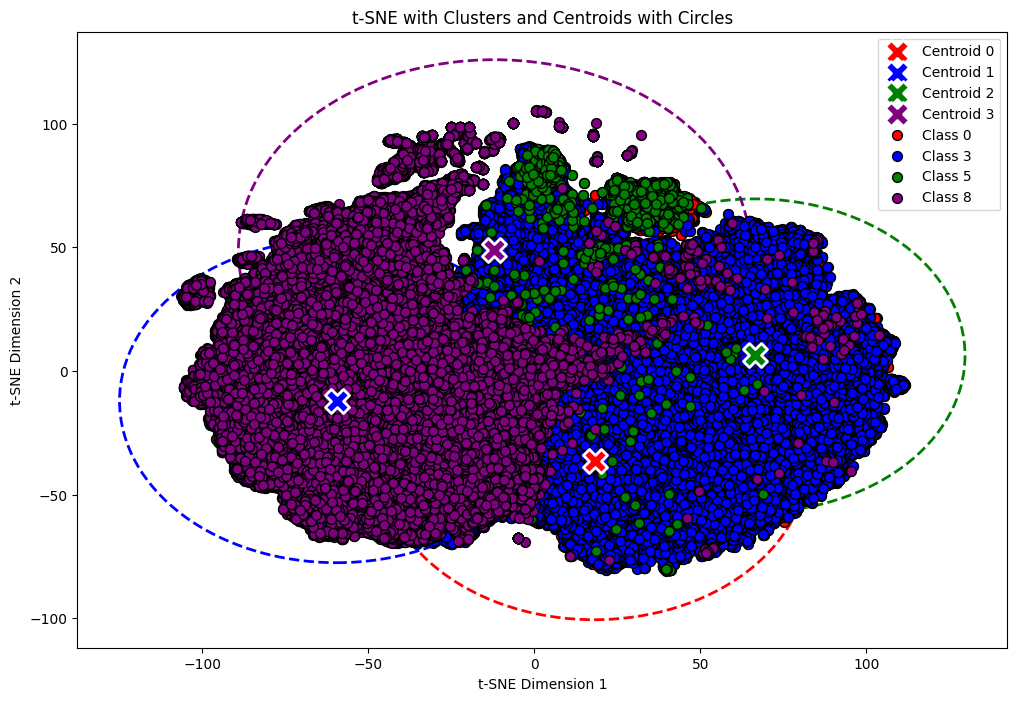

In [16]:
# Instantiate the evaluator
evaluator = KMeansEvaluator(logits_array, n_clusters=4, cluster_colors=cluster_colors, true_labels=y)

# Fit the model
evaluator.fit()

# Evaluate the model
inertia, silhouette, purity = evaluator.evaluate()
print("Inertia:", inertia)
print("Silhouette Score:", silhouette)
if purity is not None:
    print("Purity:", purity)

# Plot the clusters
evaluator.plot_clusters()
